# importing the required libraries for the analysis

pandas is a library in Python programming language for data manipulation and analysis. In particular, it offers data structures and operations for manipulating tables like Microsoft excel.

## Project Motivation

Flight delay has been a bottleneck for many travellers and flight carriers. Most times, the reason for delaying a flight is beyond these carriers. However, these delays affect travellers on getting to their destination at the appropriate time.

In 2013, it was estimated that about 36% of flights were delayed by more than five minutes in Europe, 32% of flights were delayed by more than 15 minutes in the US, and 16% of flights were cancelled or delayed greater than 30-40 minutes in Brazil. Therefore, this indicates how important this indicator is and how it acts no matter how wide the scale of airline is. 

Hence, the insight and prediction model retrieved from this project can contribute in the form of a prototype in helping travellers to identify operational variables that contribute to delays in any airline company. To provide solution to the stated problem, the following questions will be asked and answered.

This implies that if an intending customers have information on the flight they plan to book, they can predict if that flight will be delayed for more than 15minutes

# Data Description
The data used for this project is an extract of the data provided by The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics. They tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled, and diverted flights is published in DOT's monthly Air Travel Consumer Report and in this dataset of 2015 flight delays and cancellations.


1. Month, DayofMonth, DayOfWeek
2. DepTime – departure time
3. UniqueCarrier – code of a company-career
4. Origin – flight origin
5. Dest – flight destination
6. Distance, distance between Origin and Dest airports
7. dep_delayed_15min – target

In [172]:
# importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
import statsmodels.api as sm
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report
from sklearn.metrics import average_precision_score, f1_score, precision_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV


from sklearn.preprocessing import LabelEncoder, StandardScaler

In [94]:
df_train = pd.read_csv('data/flight_delays_train.csv')

In [95]:
# we will view the first five rows of the dataset to know how the data looks like
df_train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [96]:
df_train.shape   # viewing the dimension of the data

(100000, 9)

# Data Preprocessing

as it can be seen from the head of the data, the features, Month, DayofMont and Day of week have characters attached to them which shoulnt be so, hence, we will remove this characters. Also, The DepTime feature is also in a manner that doesnt makes sense, hence we will extract the Hour of Departure from by dividing it by 100

## Cleaning the c- month, DayofMonth and DayOfWeek so as to read meaningful insights into the features

In [97]:
def remove_characters(row):
    """
    this function splits a string at the postion of "-" and selects the last item
    """
    result = row.split('-')[-1]
    return int(result)

In [98]:
def preprocess(df):
    """
    This function performs data procession on the data
    """
    df["Flight"] = df["Origin"] + "-" + df["Dest"] # concatenating the origin and destination column together
    df["Hour"] = df["DepTime"] // 100  #converting the Departure time to Hour of departure
    df['Month'] = df['Month'].map(lambda row: remove_characters(row))  # extracting th month string
    df['DayofMonth'] = df['DayofMonth'].map(lambda row: remove_characters(row))  # exteacting the day of month string
    df['DayOfWeek'] = df['DayOfWeek'].map(lambda row: remove_characters(row))  # extracting the day of week string

#     airport_to_state = pd.read_csv("../input/airport-to-statecsv/airport_to_state.csv", usecols=["airport", "state"])
#     df = X.merge(airport_to_state, left_on="Origin", right_on="airport", how="left")
    if "dep_delayed_15min" in df.columns:
        df["dep_delayed_15min"] = df["dep_delayed_15min"].map({"Y": 'Yes', "N":'No'})
    
    return df

In [99]:
df = preprocess(df_train)

In [100]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Month,100000.0,6.53764,3.413447,1.0,4.0,7.0,9.0,12.0
DayofMonth,100000.0,15.70385,8.793931,1.0,8.0,16.0,23.0,31.0
DayOfWeek,100000.0,3.95183,1.991640,1.0,2.0,4.0,6.0,7.0
DepTime,100000.0,1341.52388,476.378445,1.0,931.0,1330.0,1733.0,2534.0
Distance,100000.0,729.39716,574.616860,30.0,317.0,575.0,957.0,4962.0
Hour,100000.0,13.11958,4.771657,0.0,9.0,13.0,17.0,25.0


In [101]:
def assign_flight_number(df):
    """
    This function assigns a unique number to each flights in the dataset
    """
    flights = list(df['Flight'].unique())
    flight_dict = {}
    item = 1
    for flight in flights:
        flight_dict[flight] = item
        item += 1
    df['flight_count'] = df['Flight'].map(lambda row: flight_dict[row])
    return df

df = assign_flight_number(df)

In [102]:
def index_to_value(df, column, index_list, value_list):
    
    """
    This function converts an item index to value and the value to as the idex
    """
    
    result = dict(zip(index_list, value_list))
    df[column] = df[column].map(lambda row: result[row])
    return df

In [103]:
def process_day_month(df):
    """
    using the index_to_value function, this function converts weekday and month index to their respective names
    """
    weekdays = [u"Mon", u"Tue", u"Wed", u"Thu", u"Fr", u"Sat", u"Sun"]
    months = [u"Jan", u"Feb", u"Mar", u"Apr", u"May", u"Jun", u"Jul", u"Aug", u"Sep", u"Oct", u"Nov", u"Dec"]
    
    month_index = sorted(df['Month'].unique())
    day_index = sorted(df['DayOfWeek'].unique())
    
    df = index_to_value(df, 'Month', month_index, months)
    df = index_to_value(df, 'DayOfWeek', day_index, weekdays)
    
    return df

df = process_day_month(df)

In [104]:
def process_period(df):
    """
    This function divides the hour of a day into the morning, afternoon and night
    """
    df.loc[(df['Hour'] >= 0) & (df['Hour'] < 12), 'Period'] = 'Midnight - Morning'
    df.loc[(df['Hour'] >= 12) & (df['Hour'] <= 17), 'Period'] = 'Noon'
    df.loc[df['Hour'] > 17, 'Period'] = 'Evening - Night'
    
    return df

df = process_period(df)

# Data Exploration

To have better understanding of the data and provide insight into the data, the following questions are asked and answered;
1. How is the delay of flights distributed
2. How is flight delay distributed among the days of the week
3. How is flight delay distributed over period of the day
4. How are delayed flights distributed over the months
5. How are delayed flights distributed over the UniqueCarriers
6. What is the monthly average hour of the delayed flights
7. what is the hourly average distance of destination delayed flights
8. What is the daily average hour of the delayed flights

## How is the delay of flights distributed

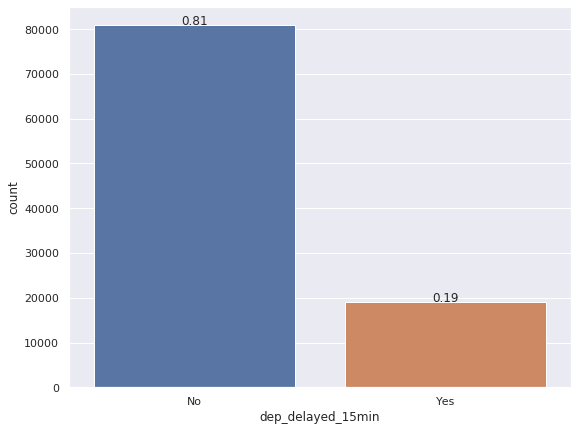

In [148]:
def plot_bar(x, filename, df, hue=None):
    """
    This function plots and saves a bar chart with hue if specified
    """
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,7))
    ax = sns.countplot(x=x, data=df, ax = axes, hue=hue);

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}'.format(height/float(len(df))),
                ha="center")

    plt.savefig('plots/'+filename+'.png')

plot_bar(x='dep_delayed_15min', filename='target', df=df)

## What is the distribution of the distance between origin and destination

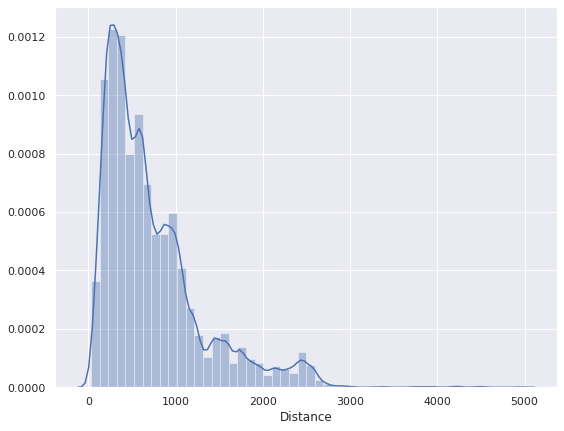

In [92]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,7))
sns.distplot(df['Distance'], ax=ax);

plt.savefig('plots/distance.png')

# Understanding the distribution of delayed flights over day, month, hour of flight, distance, and flight carrier

Since our major objective is to understand how flights that are delayed are distributed, we will only focus on the delayed flights over the above features. 

To do this, we will select only the flights that were delayed and examine their distribution accross all the features highlighted above

In [20]:
delayed_df = df[df['dep_delayed_15min'] == 'Yes']  # filtering the data for only when delay equal yes

## How is flight delay distributed among the days of the week

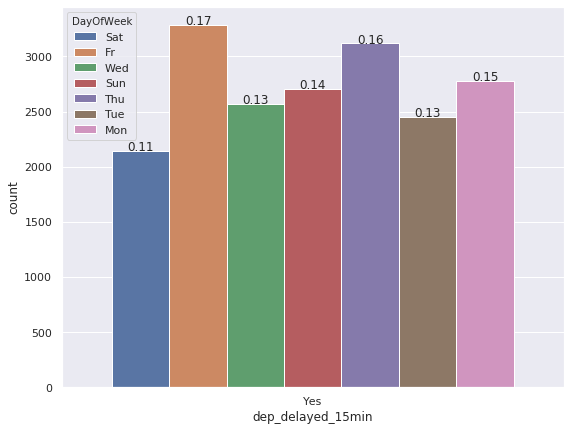

In [149]:
plot_bar(x='dep_delayed_15min', filename='day_of_week', df=delayed_df, hue='DayOfWeek')

## How is flight delay distributed over period of the day

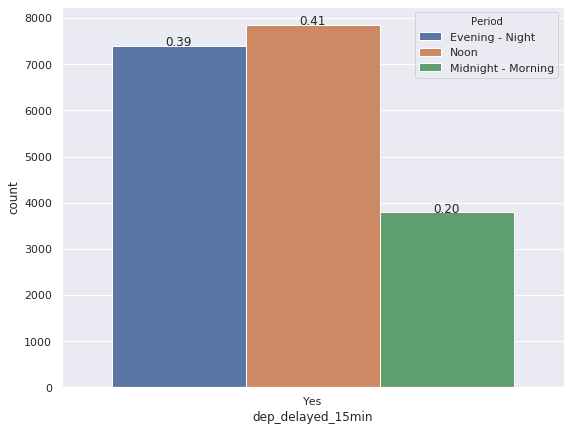

In [150]:
plot_bar(x='dep_delayed_15min', filename='Period', df=delayed_df, hue='Period')

## How are delayed flights distributed over the months

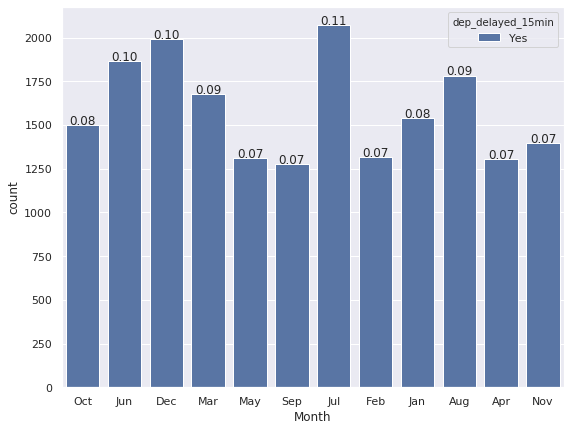

In [151]:
plot_bar(x='Month', filename='months', df=delayed_df, hue='dep_delayed_15min')

## How are delayed flights distributed over the UniqueCarriers

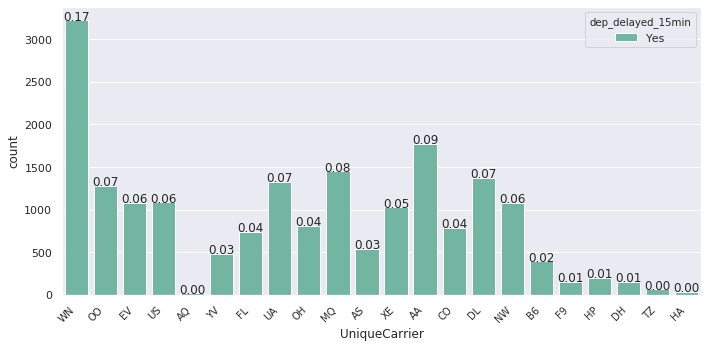

In [88]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='UniqueCarrier', hue='dep_delayed_15min', data=delayed_df, palette='Set2');
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'  
);
plt.tight_layout()

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/float(len(delayed_df))),
            ha="center")
plt.savefig('plots/unique_carriers.png')

## What is the monthly average hour of the delayed flights

In [ ]:
def plot_line(df, index, columns, values,filename, agg=None):

    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
    df.pivot_table(index=index, columns=columns, values=values, aggfunc=agg).plot(ax=ax);
    plt.savefig('plots/'+filename+'.png')

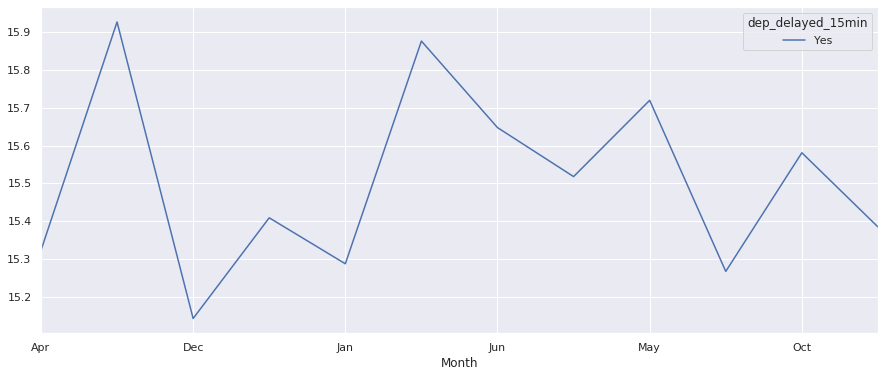

In [157]:
plot_line(delayed_df, index='Month', filename='average_monthly',columns='dep_delayed_15min', values='Hour', agg='mean')

## what is the hourly average distance of destination delayed flights

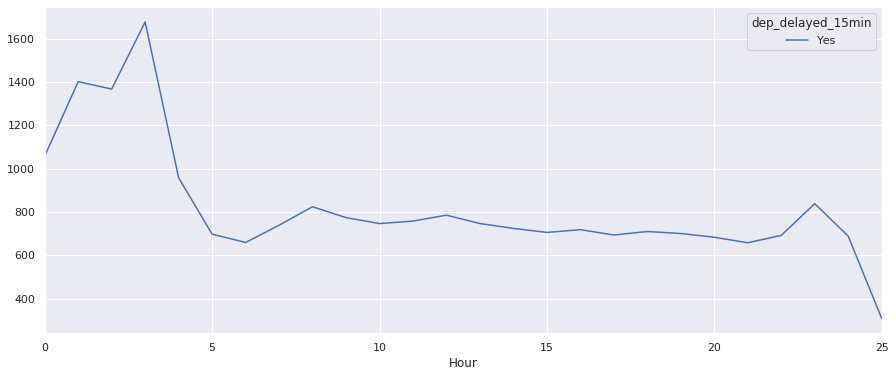

In [154]:
plot_line(delayed_df, index='Hour', filename='average_distance',columns='dep_delayed_15min', values='Distance', agg='mean')

## What is the daily average hour of the delayed flights

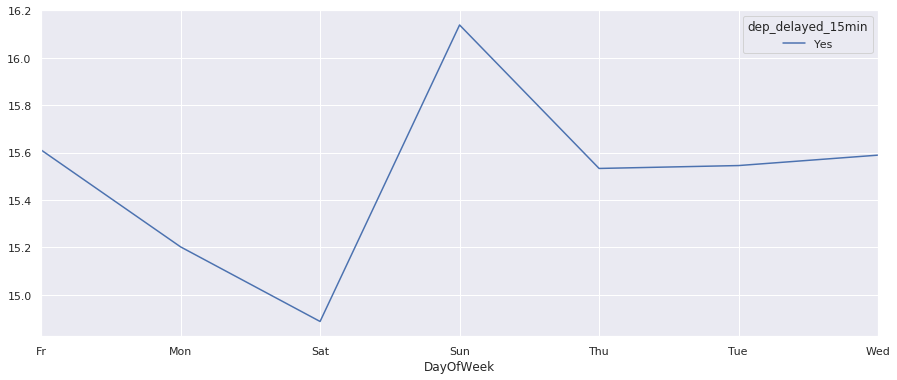

In [156]:
plot_line(delayed_df, index='DayOfWeek', filename='average_daily',columns='dep_delayed_15min', values='Hour', agg='mean')

# Model Estimation

In [36]:
# encoding the unique carrier feature so the learning algorithm can make sense of it
carrier_encoded = le.fit_transform(df['UniqueCarrier'])
df['carrier_encoded'] = carrier_encoded

In [28]:
le = LabelEncoder()

In [41]:
def prepare_model_data(df):
    """
    This functions selects the features to be used from the whole dataset and prepare the for the model
    """
    cat_vars = df[['Month', 'DayofMonth','DayOfWeek']]
    cat_features = pd.get_dummies(cat_vars, drop_first=True)  # creating dummy variables of the categorical features
    other_features = df[['Hour', 'Distance', 'carrier_encoded']]
    X = pd.concat([cat_features, other_features], axis=1)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

    return X_scaled
X = prepare_model_data(df)

In [42]:
X.head()

,DayofMonth,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,...,Month_Sep,DayOfWeek_Mon,DayOfWeek_Sat,DayOfWeek_Sun,DayOfWeek_Thu,DayOfWeek_Tue,DayOfWeek_Wed,Hour,Distance,carrier_encoded
0,0.602254,3.213258,-0.300161,-0.283061,-0.296384,-0.308808,-0.303101,-0.306646,-0.305631,-0.298435,...,-0.298137,-0.412959,-0.383628,2.468544,-0.415726,-0.41354,-0.411947,1.232371,0.004530,-1.834390
1,0.488538,-0.311211,-0.300161,-0.283061,-0.296384,-0.308808,-0.303101,-0.306646,-0.305631,-0.298435,...,-0.298137,-0.412959,-0.383628,-0.405097,-0.415726,-0.41354,2.427498,0.394083,0.182040,0.906906
2,-1.558338,-0.311211,-0.300161,-0.283061,-0.296384,-0.308808,-0.303101,-0.306646,-0.305631,-0.298435,...,3.354161,-0.412959,-0.383628,-0.405097,-0.415726,-0.41354,-0.411947,0.184511,-0.545405,1.211494
3,1.057115,-0.311211,-0.300161,-0.283061,-0.296384,-0.308808,-0.303101,-0.306646,-0.305631,3.350810,...,-0.298137,-0.412959,2.606691,-0.405097,-0.415726,-0.41354,-0.411947,-0.653776,0.248172,0.450023
4,-0.989761,-0.311211,-0.300161,-0.283061,-0.296384,-0.308808,-0.303101,-0.306646,-0.305631,-0.298435,...,-0.298137,-0.412959,2.606691,-0.405097,-0.415726,-0.41354,-0.411947,1.022799,-0.533223,1.059200


In [84]:
models = [('lr', LogisticRegression(max_iter=2000)), 
          ('knn', KNeighborsClassifier()), 
          ('cart', DecisionTreeClassifier()), 
          ('forest', RandomForestClassifier()),
          ('bayes', GaussianNB()),
          ('gradient', GradientBoostingClassifier())]

In [43]:
y = df.pop('dep_delayed_15min')
y = y.map({'Yes':1, 'No':0})

In [158]:
# splitting into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [162]:
def train_model(X, y, model):
    """
    This function build trains a model using extracted features
    
    Input:
        X (matrix, dataframe): This is the feature(s) which we want to use to fit a model
        Y (series): This is the target feature that we want to predict
    
    Output:
        y_test (series): a subset of the target variable that will be used to evaluate the model
        y_pred (series): the predicted y using the trained model
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)
    
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return y_test, y_pred

In [183]:
def plot_model(model_names, score):
    """
    This function plots a line graph with two lines indicating the accuracy and recall of the model
    """
    # create figure and axis objects with subplots()
    fig,ax = plt.subplots(figsize=(8,6))
    # make a plot
    ax.plot(model_names, score)
    
    ax.set_ylabel("Score",color="blue",fontsize=18)
    plt.ylim((0,1))
    
    plt.savefig('plots/model_eval')

In [184]:
def evaluate_model(X, y, models, clf):
        
    """
    This function trains various and evaluates them to observe the best model
    
    Input:
        X (matrix, dataframe): the input features
        y (series): the target feature
        models: a dictionary of models that will be trained
    
    """
#     accuracy = {}
    precision = {}
    for i in range(len(models)):
        model = models[i]

        y_test_text, y_pred_text = clf(X, y, model[1])
#         accuracy[model[0]] = accuracy_score(y_test_text, y_pred_text)
        precision[model[0]] = average_precision_score(y_test_text, y_pred_text)
    
    model_names = list(precision.keys())
#     f1scores = list(f1score.values())
    precision_list = list(precision.values())
    plot_model(model_names, precision_list)

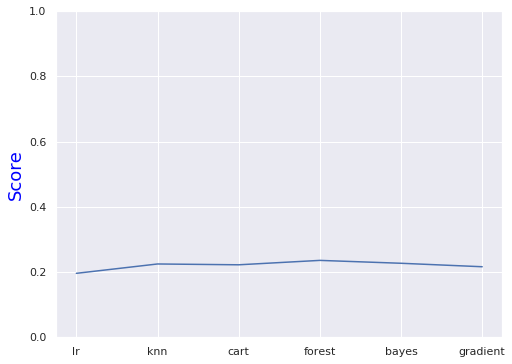

In [185]:
evaluate_model(X, y, models, train_model)

In [ ]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [186]:
# A sample parameter

parameters = {
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "n_estimators":[10]
    }
#passing the scoring function in the GridSearchCV
clf = GridSearchCV(RandomForestClassifier(), parameters,scoring='average_precision',refit=False,cv=2, n_jobs=-1)
clf.fit(X, y)

GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
                         'min_samples_leaf': array([0.1       , 0.13636364, 0.17272727, 0.20909091, 0.24545455,

In [188]:
clf.best_score_

0.30729492485144677

In [213]:
model = DecisionTreeClassifier(max_depth=7)
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [214]:
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

In [218]:
print(accuracy_score(y_train,y_train_pred))
print(accuracy_score(y_test, y_pred))

0.8136417910447761
0.8133333333333334


In [252]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90     26723
           1       0.60      0.05      0.10      6277

    accuracy                           0.81     33000
   macro avg       0.71      0.52      0.50     33000
weighted avg       0.78      0.81      0.74     33000



In [256]:
print(confusion_matrix(y_test,y_pred))

[[26502   221]
 [ 5939   338]]


In [177]:
print(sklearn.metrics.SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])
